Tomado de https://colab.research.google.com/github/cbernet/maldives/blob/master/imdb/imdb_embed.ipynb#scrollTo=sp1T1vc6MqHt
## El dataset IMDB

Se utiliza el  dataset IMDB dataset, que contiene 25000 reseñas de películas provenientes de IMDB (https://www.imdb.com/). Cada reseña se etiqueta como positiva o negativa a partir de la calificación proporcionada por los usuarios junto con sus reseñas. 

El conjunto de datos se distribuye con keras. Antes de cargarlo en memoria, se consideran algunas herramientas:

In [1]:
# Se obtienen resultados reproducibles
from numpy.random import seed
seed(0xdeadbeef)
import tensorflow as tf
tf.random.set_seed(0xdeadbeef)

In [2]:
#Se importa desde tensorflow la librería keras, se define un lote de 20000 elementos y se definen los datasets de entrenamiento (train_data) y prueba (test_data)
from tensorflow import keras
imdb = keras.datasets.imdb
num_words = 20000
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(seed=1, num_words=num_words)

17473536/17464789 [==============================] - 0s 0us/step


At the moment, `imdb.load_data` triggers deprecation warnings that can be ignored.

Una primera revisión del dataset de entrenamiento train_data

In [3]:
print(train_data[0])
print('label:', train_labels[0])

[1, 13, 28, 1039, 7, 14, 23, 1856, 13, 104, 36, 4, 699, 8060, 144, 297, 14, 175, 291, 18, 4, 375, 1784, 153, 38, 15, 75, 92, 859, 51, 16, 5, 15, 75, 377, 24, 8, 81, 4, 172, 2497, 174, 40, 1489, 49, 84, 11, 4, 2030, 3039, 121, 36, 92, 4881, 14, 20, 2, 9, 40, 6, 2, 621, 18, 148, 37, 191, 1941, 42, 511, 14, 20, 9, 17, 76, 253, 17, 269, 8, 3336, 4, 2, 8, 1278, 6, 543, 2647, 10, 10, 308, 3102, 2, 47, 43, 188, 46, 7, 1172, 5, 240, 2854, 145, 8, 4, 154, 3243, 11, 4819, 58, 18, 35, 32, 8, 327, 823, 7, 7350, 7, 265, 308, 1828, 145, 1646, 4, 154, 890, 5, 9, 14412, 34, 362, 2515, 154, 1914, 5, 27, 15227, 2, 17, 36, 837, 5, 1941, 32, 367, 4, 96, 10, 10, 13, 62, 386, 14, 48, 13, 16, 3178, 42, 48, 11, 882, 294, 16, 3412, 2, 4360, 2, 34, 6, 1042, 18, 2, 345, 96, 14, 9, 6, 862, 526, 3757, 917, 5, 60, 1055, 13, 115, 197, 474, 1829, 15, 2006, 7, 6791, 113, 19, 4, 2, 261, 13, 104, 4, 1653, 173, 7, 4, 65, 143, 4, 3801, 1366, 548, 844, 5, 4, 837, 1396, 27, 369, 459, 44, 68, 4731, 5, 181, 8, 607, 4, 6791, 3

Vemos que el texto de la reseña se ha codificado como una secuencia de números enteros. 

Cada palabra del texto se representa como un número entero. Un diccionario llamado vocabulario vincula cada palabra a un entero único. En el ejemplo anterior, vemos que el número entero 4 se repite muchas veces. Este entero corresponde a una palabra muy frecuente. Y, de hecho, cuanto más frecuente es una palabra, menor es el número entero.

Para decodificar la reseña, se usa el vocabulario:

In [4]:
# Un diccionario que asigna palabras a un índice entero
vocabulary = imdb.get_word_index()

# Los primeros índices están reservados
vocabulary = {k:(v+3) for k,v in vocabulary.items()} 
vocabulary["<PAD>"] = 0
# Vea cómo el entero 1 aparece primero en la revisión anterior. 
vocabulary["<START>"] = 1
vocabulary["<UNK>"] = 2  # unknown (desconocido)
vocabulary["<UNUSED>"] = 3

# invirtiendo el vocabulario.
# en el índice, la clave es un número entero,
# y el valor es la palabra correspondiente.
index = dict([(value, key) for (key, value) in vocabulary.items()])

def decode_review(text):
    '''converts encoded text to human readable form.
    each integer in the text is looked up in the index, and 
    replaced by the corresponding word.
    '''
    return ' '.join([index.get(i, '?') for i in text])


1654784/1641221 [==============================] - 0s 0us/step


In [5]:
decode_review(train_data[0])

"<START> i have copy of this on vhs i think they the television networks should play this every year for the next twenty years so that we don't forget what was and that we remember not to do the same mistakes again like putting some people in the director's chair where they don't belong this movie <UNK> is like a <UNK> musical for those who can't sing or act this movie is as much fun as trying to teach the <UNK> to drive a city bus br br john hood <UNK> has just got out of prison and he's headed back to the old neighborhood in serving time for an all to nice crime of necessity of course john heads back onto the old street and is greeted by kids dogs old ladies and his peer <UNK> as they dance and sing all along the way br br i would recommend this if i was sentimental or if in truth someone was smoking <UNK> pot <UNK> by a doctor for <UNK> either way this is a poorly directed scripted acted and even produced i never thought i'd sat that satire of ghetto life with the <UNK> although i t

Vemos que el entero 4 corresponde efectivamente a una palabra muy frecuente, "the". Ahora, se observa dos problemas a resolver para poder usarlo como entrada a una red neuronal:

*   Las reseñas tienen un número variable de palabras, mientras que la red tiene un número fijo de neuronas.
*   Las palabras son completamente independientes. Por ejemplo, "brillante" y "impresionante" corresponden a dos números enteros diferentes, y la red neuronal no sabe a priori que estos dos adjetivos tienen un significado similar.


Para resolver el primer problema, y obtener una entrada de longitud fija, simplemente podemos truncar las reseñas a un número fijo de palabras (256 por ejemplo). Para las reseñas que tienen más de 256 palabras, se mantienen solo las primeras 256 palabras. Para reseñas más cortas, se llenan los espacios de palabras no utilizados con ceros. Con keras, esto es fácil de hacer:

In [6]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=vocabulary["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=vocabulary["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [7]:
#Se visualiza el dataset de entrenamiento train_data
train_data[1]

array([    1,   103,   450,   576,    73,  2896,     8,     4,   213,
           7,   897,    13,    16,   576,  3521,    19,     4,    22,
           4,    22,    16,   465,   728,     4,  2563,     4,  1460,
           4,  3237,     5,     6,    55,   576,  1078,  2734,    10,
          10,    13,    69,  2721,   873,     8,    67,   111,   318,
         302,     5,    40,     6, 13892,     2,    12,  4280,    72,
         245,    19,     4,  4211,     5,     4,     2,     7,    12,
        1620,    13,   244,   174,  2654,   245,    19,   129,  7102,
          19,     4,   979,     7,     4,    65,     5,   129,   459,
           7,     4,   318,   302,    25,    80,   140,     6,   196,
          96,    61,   464,    13,    80,   407,    30,     4,  2217,
           7,   129,   337,  1333,    10,    10,  2127,     2,     4,
         118,   284,  1344,    16,     4,   612,    31,  1099,    25,
          93,  1792,  7606,   168,    40,     6,   506,  1079,     8,
           2,    10,

El primer problema está resuelto: las reseñas ahora tienen una duración fija. El segundo tema se aborda a continuación.

En esta sección, veremos por qué una red neuronal densa estándar es esencialmente incapaz de manejar este conjunto de datos.

Las redes neuronales son simplemente una función de sus entradas. En la red de 1 neurona (o regresión logística), esta función es 

$$ f( \{ x_i \} ) = \sigma (z)$$

donde $\sigma$ es la función sigmoide y donde la entrada de pesos $z$ de una sola neurona of se calcula como:

$$z= b+ \sum_{i} w_i x_i$$ 

En esta expresión, la suma se ejecuta sobre todas las variables de entrada  $x_i$, y $b$ es el sesgo de la neurona. Cuando se entrena la red, los parámetros de la red (los sesgos y los pesos) se ajustan para obtener el mejor rendimiento.

Ahora, ¿qué pasaría si intentáramos clasificar nuestras reseñas como positivas o negativas con una regresión logística?

Las variables de entrada serían los 256 enteros en la matriz de revisión. Supongamos un peso positivo $w_i$ para la variable i. Dado que la función sigmoidea aumenta monótonamente, cuando la variable $i$ aumenta, aumenta la salida de la red, que es la probabilidad de que la revisión sea positiva.

¡Pero no hay razón para que la variable $i$ se correlacione de ninguna manera con la probabilidad de que la revisión sea positiva!

Por ejemplo, la variable $i$ podría ser 27 (correspondiente a la palabra "malo"), 118 ("bueno") o 1562 ("horrible"). La revisión no parece más positiva cuando el número entero se hace más grande.
En otras palabras, el valor real del código entero de una palabra determinada no aporta información por sí mismo sobre la calidad de la reseña. Este valor es arbitrario y sería diferente con otro algoritmo de codificación. 

Claramente, una regresión logística no sería de ninguna utilidad para clasificar nuestras revisiones.

¿Tal vez la regresión logística es demasiado simple y una red densa más compleja ayudaría?

En realidad, ese no es el caso. De hecho, en una red densa con capas ocultas, cada una de las neuronas de la primera capa oculta se comporta como la única neurona de la regresión logística. Entonces, las redes densas más complejas sufren los mismos problemas que la regresión logística simple.

## Análisis de sentimiento simple con embedding

Embedding es una forma de extraer el significado de una palabra. En el proceso de incrustación, cada palabra (o más precisamente, cada número entero correspondiente a una palabra) se traduce a un vector en un espacio N-dimensional.

¡Eso suena complicado! pero no lo es.

Para entenderlo mejor, vamos a realizar la incrustación solo en dos dimensiones. Luego, cada palabra se convertirá en un vector con dos coordenadas. $(x,y)$, y estas coordenadas se pueden representar como un punto en un plano.

Como se ve a continuación, el texto de una reseña aparecerá como un conjunto de puntos, y los puntos con un significado similar se agruparán. Al observar la distribución de los puntos en 2D, la red neuronal podrá predecir si la revisión es positiva o negativa.

En la práctica, aquí está cómo hacerlo en keras.

In [8]:

model = keras.Sequential()

# la primera capa es la capa de incrustación.
# se indica el número de palabras posibles,
# la dimensión del espacio de incrustación,
# y el tamaño máximo del texto. 
model.add(keras.layers.Embedding(len(vocabulary), 2, input_length=256))

# la salida de la incrustación es multidimensional,
# con forma (256, 2)
# para cada palabra, obtenemos dos valores,
# las coordenadas x e y
# aplanamos esta salida para poder
# usarlo en una capa densa
model.add(keras.layers.Flatten())

# regularización dropout para evitar el sobreajuste
model.add(keras.layers.Dropout(rate=0.5))

# pequeña capa densa. Su función es analizar
# la distribución de puntos de incrustación
model.add(keras.layers.Dense(5))

# neurona final, con activación sigmoidea
# para clasificación binaria
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 2)            177176    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 179,747
Trainable params: 179,747
Non-trainable params: 0
_________________________________________________________________


Como puede ver, basta con agregar una embedding layer a la red neuronal para realizar la incrustación. Y como se ve solo hay que proporcionar tres argumentos para construir la embedding layer (capa de incrustación): la longitud del vocabulario, la cantidad de dimensiones en el espacio de incrustación (embedding space) y la cantidad de palabras en el texto de entrada.

En la impresión de resumen justo arriba, se ve que la embedding layer representa 177176 parámetros. Al principio, estos parámetros son aleatorios y la incrustación no tiene sentido. Durante el entrenamiento, estos parámetros se ajustan y la red se vuelve cada vez más capaz de extraer el significado de las palabras.

Ahora que el modelo está listo, se compila y lo entrena. Aquí no se necesita una GPU, ya que el entrenamiento será bastante rápido incluso en una CPU.

In [9]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [10]:
history = model.fit(train_data,
                    train_labels,
                    epochs=5,
                    batch_size=100,
                    validation_data=(test_data, test_labels),
                    verbose=1)

Epoch 1/5
250/250 [==============================] - 3s 10ms/step - loss: 0.6818 - accuracy: 0.5660 - val_loss: 0.6192 - val_accuracy: 0.7286
Epoch 2/5
250/250 [==============================] - 2s 10ms/step - loss: 0.4416 - accuracy: 0.8093 - val_loss: 0.3455 - val_accuracy: 0.8595
Epoch 3/5
250/250 [==============================] - 2s 9ms/step - loss: 0.2979 - accuracy: 0.8767 - val_loss: 0.3062 - val_accuracy: 0.8743
Epoch 4/5
250/250 [==============================] - 2s 9ms/step - loss: 0.2471 - accuracy: 0.9006 - val_loss: 0.2899 - val_accuracy: 0.8822
Epoch 5/5
250/250 [==============================] - 2s 10ms/step - loss: 0.2189 - accuracy: 0.9106 - val_loss: 0.2928 - val_accuracy: 0.8778


Ahora se puede ver la evolución de las precisión del entrenamiento y prueba en función del tiempo, con esta pequeña función:

In [11]:
import matplotlib.pyplot as plt
def plot_accuracy(history, miny=None):
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.title('accuracy') 
  plt.xlabel('epoch')
  plt.figure()

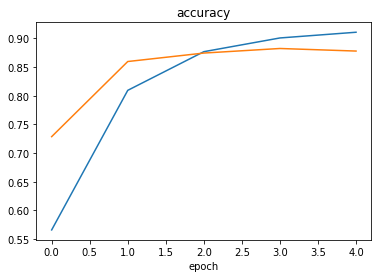

<Figure size 432x288 with 0 Axes>

In [12]:
plot_accuracy(history)

El modelo alcanza una precisión de clasificación superior al 85%. La precisión del entrenamiento aumenta continuamente mientras que la precisión del entrenamiento se estanca después de la segunda época. Esto significa que el modelo tiene un sobreajuste.

## Visualizando el embedding

Para investigar la incrustación, se crea una función que proporciona la salida de la capa de incrustación para una entrada determinada:

In [13]:

# Con un modelo secuencial
get_embed_out = keras.backend.function(
    [model.layers[0].input],
    [model.layers[1].output])

Luego, se usa esta función para obtener la distribución de puntos de la incorporación de la primera revisión en la muestra de validación:

In [14]:
layer_output = get_embed_out([test_data[0]])
print(type(layer_output), len(layer_output), layer_output[0].shape)

<class 'list'> 1 (256, 2)


Se observa que layer_output es una lista con un solo elemento que contiene la matriz de palabras incrustadas. Así que se puede obtener esta matriz y graficarla:

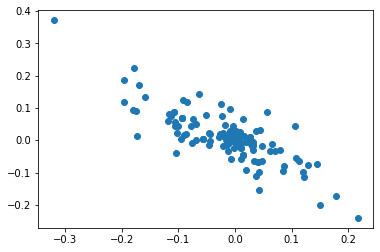

In [15]:
words = layer_output[0]
plt.scatter(words[:,0], words[:,1])

Se observa que la distribución de palabras incrustadas para esta revisión tiene una forma alargada. Pero, ¿qué significa?

Ahora, se crea una revisión propia, codificada e incrustada para ver qué sucede:

In [16]:
review = ['great', 'brilliant','crap','bad', 
          'fantastic', 'movie', 'seagal']
enc_review = tf.constant([vocabulary[word] for word in review])
enc_review

<tf.Tensor: shape=(7,), dtype=int32, numpy=array([  87,  530,  595,   78,  777,   20, 3272], dtype=int32)>

In [17]:
words = get_embed_out([enc_review])[0]

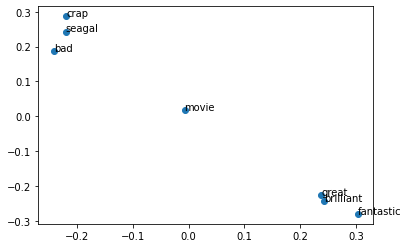

In [18]:
plt.scatter(words[:,0], words[:,1])
for i, txt in enumerate(review):
    plt.annotate(txt, (words[i,0], words[i,1]))

Vemos que las palabras con un significado similar se agrupan. Hay un grupo con "great", "brillant", "fantastic". Esta área del plano contiene las palabras que tienen un significado positivo. Por otro lado, tenemos "bad", "crap" y ... "seagal". ¡Parece que contratar a Steven Seagal para su película garantiza malas críticas en IMDB!

La palabra "película", finalmente, no tiene mucho significado sobre la calidad de la reseña, y termina en el medio.

**Ejercicio**: Encontrar a un un buen actor

Ahora, tracemos la distribución de puntos para algunas revisiones con la siguiente función: 

In [19]:
import math
def plot_review(i):
    # plot the distribution of points
    enc_words = test_data[i]
    emb_words = get_embed_out([enc_words])[0]
    plt.figure(figsize=(8,8))
    plt.scatter(emb_words[:,0], emb_words[:,1])
    # use la etiqueta como título: 1 es positivo, 
    # 0 es negavtivo
    plt.title(test_labels[i])
    # para palabras que están bastante lejos desde (0,0), 
    # imprime la palabra
    for i, (enc_word, emb_word) in enumerate(zip(enc_words, emb_words)):
        word = index[enc_word]
        x, y = emb_word
        if math.sqrt(x**2 + y**2)>0.2: 
            plt.annotate(word, (x, y))
    # fija el rango en x e y para poder comparar
    # la distribución de las difrentes reseñas
    axes = plt.gca()
    axes.set_xlim([-0.5,0.5])
    axes.set_ylim([-0.5, 0.5])
    axes.set_aspect('equal', adjustable='box')

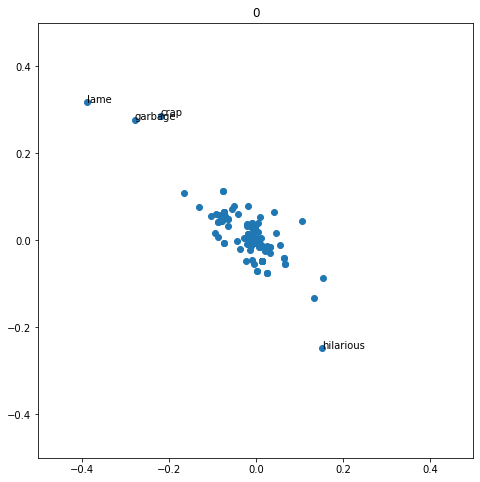

In [20]:
plot_review(15)

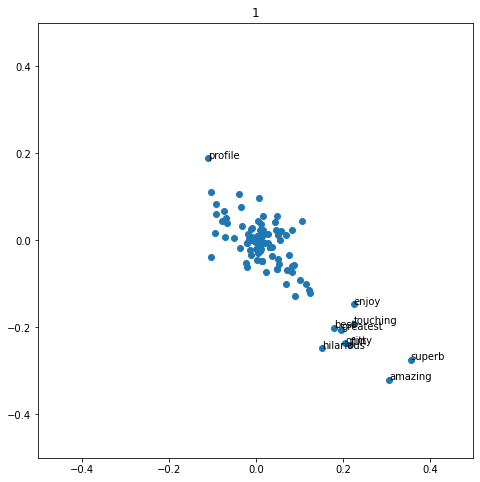

In [21]:
plot_review(17)

Puede trazar algunas revisiones más si lo desea, cambiando el índice de revisión en los comandos anteriores.

Se ve que las críticas positivas tienden a tener palabras con un significado similar a "genial", "brillante" y "fantástico", mientras que las críticas negativas tienden a tener palabras con un significado similar a "seagal".

El objetivo de la capa densa en nuestra esta red es resumir la información en toda la distribución de puntos para cada revisión.

